In [1]:
# 
import pandas as pd
import numpy as np

# Viz
import seaborn as sns
import matplotlib.pyplot as plt


# Pipeline
from src.data_creator import DataGenerator
from src.mltracker import MultiTracker
from src.column_analyzer import ColAnalyzer
 
import wandb
import mlflow


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, KFold


# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score



# Metrics Regression
from sklearn.metrics import make_scorer, calinski_harabasz_score, silhouette_score
from  sklearn.metrics import (mean_squared_error,
 mean_absolute_error, r2_score, explained_variance_score,
  mean_pinball_loss, d2_pinball_score,  d2_absolute_error_score)

# Functions



In [2]:
def adjusted_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    n_samples = len(y_true)
    
    adjusted_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)
    
    return adjusted_r2

# Data Creation

### Regression Data

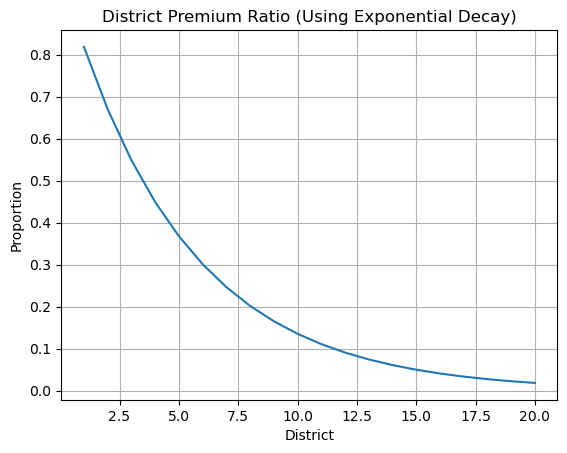

In [3]:
decay_rate = 0.2
x = np.arange(1, 21)
y = np.exp(-decay_rate * x)

plt.plot(x, y)
plt.xlabel('District')
plt.ylabel('Proportion')
plt.title('District Premium Ratio (Using Exponential Decay)')
plt.grid(True)
plt.show()

In [4]:
# Creation of a fake data set
data_size = 100
base_price = 8_000

df = pd.DataFrame({

  'm2': np.random.randint(10, 121, data_size),
  'floor_level': np.random.randint(0, 10, data_size),
  'district': np.random.randint(1, 21, data_size),
  'balconies_count': np.random.randint(0,3, data_size),
  'cave_m2':np.random.randint(0,15, size=data_size)
})

district_premium = np.exp(-0.2 * df.district)
floor_premium = np.exp(df.floor_level * 0.2)
balcony_price = base_price/8 

error = np.random.normal(size=df.shape[0])*5_000

df['price'] = (district_premium + floor_premium)  * ( df.balconies_count +  df.m2*base_price + df.cave_m2 * base_price/10 ) + error
df['price'] = df['price']/1_000

df.head(3)

,m2,floor_level,district,balconies_count,cave_m2,price
0,70,5,20,1,3,1535.069068
1,34,7,16,1,6,1132.085173
2,96,5,8,2,11,2264.324360


In [5]:
# from matplotlib.ticker import FuncFormatter
# def thousands_formatter(x, pos):
#     return f'{int(x/1000)}M'

# sns.scatterplot(data=df, x=df.m2, y=df.price, hue=df.district, style=df.balconies_count ,size=df.cave_m2 ,  palette='tab20', sizes=(10, 100), alpha=0.9)

# plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=4)

### Cluster Data 

In [6]:
dg = DataGenerator()
dg.generate_cluster('circles', noise=0.02)
# dg.plot()

,feature1,feature2,true_cluster,feature3,feature4,category
0,-0.278112,0.409024,1,-0.264606,0.900929,C
1,0.127730,-0.492761,1,0.124618,0.869827,A
2,0.470118,0.041148,1,0.465946,1.014099,B
3,0.910516,0.387668,0,0.820281,0.938000,C
4,-0.471349,-0.167179,1,-0.458771,0.985640,C
...,...,...,...,...,...,...
295,0.005863,0.512264,1,-0.007995,0.861437,C
296,-0.960271,0.188013,0,-0.801355,0.976980,C
297,-0.277995,-0.950504,0,-0.268282,0.561698,B
298,0.123977,-0.476686,1,0.139917,0.879634,B


# Pipeline

In [9]:
#Get columns info
data = dg.data.copy()
cola = ColAnalyzer(data).column_types_

# Defining column transformations for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cola['numeric']),
        ('cat', OneHotEncoder(), cola['categorical'])
    ]
)

# Model Pipelines with parameter grids
model_pipelines = {
    'kmeans': {
        'model': KMeans(),
        'params': {'model__n_clusters': [2, 3, 4]}
    },
    'gmm': {
        'model': GaussianMixture(),
        'params': {'model__n_components': [2, 3, 4]}
    },
    'dbscan': {
        'model': DBSCAN(),
        'params': {'model__eps': [0.3, 0.5, 0.7], 'model__min_samples': [5, 10]}
    },
    'spectral': {
        'model': SpectralClustering(),
        'params': {'model__n_clusters': [2, 3, 4], 'model__affinity': ['nearest_neighbors', 'rbf']}
    }
}

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the multi-platform tracker
tracker = MultiTracker(
    tracking_platforms=["mlflow", "wandb"],
    experiment_name="clustering_comparison",
    project_name="clustering_analysis",
    tags={"task": "clustering", "dataset": data.shape}
)

# Dictionary to store cross-validated results for each model
results = {}



from sklearn.metrics import make_scorer, calinski_harabasz_score, silhouette_score

def ch_scorer(estimator, X):
    """Calinski-Harabasz scorer for GridSearchCV"""
    labels = estimator.named_steps['model'].fit_predict(X)
    return calinski_harabasz_score(X, labels)

def silhouette_scorer(estimator, X):
    """Silhouette scorer for GridSearchCV"""
    labels = estimator.named_steps['model'].fit_predict(X)
    return silhouette_score(X, labels)

# Create custom scorers
scoring = {
    'calinski_harabasz': make_scorer(ch_scorer),
    'silhouette': make_scorer(silhouette_scorer)
}



In [10]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, calinski_harabasz_score, silhouette_score
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
import mlflow
import wandb
from abc import ABC, abstractmethod
from contextlib import contextmanager
from typing import List, Dict, Any, Optional, Generator, Union
from dataclasses import dataclass
import os

class BaseTracker(ABC):
    @abstractmethod
    def start_run(self, run_name: Optional[str] = None, nested: bool = False) -> Any:
        pass
    
    @abstractmethod
    def end_run(self) -> None:
        pass
    
    @abstractmethod
    def log_metrics(self, metrics: Dict[str, float]) -> None:
        pass
    
    @abstractmethod
    def log_params(self, params: Dict[str, Any]) -> None:
        pass
    
    @abstractmethod
    def log_artifacts(self, local_path: str, artifact_path: Optional[str] = None) -> None:
        pass
    
    @abstractmethod
    def set_tags(self, tags: Dict[str, Any]) -> None:
        pass

class MLflowTracker(BaseTracker):
    def __init__(self, experiment_name: str):
        self.experiment_name = experiment_name
        self.active_run = None
        mlflow.set_experiment(experiment_name)
        try:
            mlflow.end_run()
        except Exception:
            pass
    
    def start_run(self, run_name: Optional[str] = None, nested: bool = False) -> mlflow.ActiveRun:
        if nested:
            self.active_run = mlflow.start_run(run_name=run_name, nested=True)
        else:
            if mlflow.active_run():
                mlflow.end_run()
            self.active_run = mlflow.start_run(run_name=run_name)
        return self.active_run
    
    def end_run(self) -> None:
        if self.active_run:
            mlflow.end_run()
            self.active_run = None
    
    def log_metrics(self, metrics: Dict[str, float]) -> None:
        if self.active_run:
            metrics = {k: float(v) for k, v in metrics.items() if isinstance(v, (int, float))}
            mlflow.log_metrics(metrics)
    
    def log_params(self, params: Dict[str, Any]) -> None:
        if self.active_run:
            mlflow.log_params(params)
    
    def log_artifacts(self, local_path: str, artifact_path: Optional[str] = None) -> None:
        if self.active_run:
            mlflow.log_artifact(local_path, artifact_path)
    
    def set_tags(self, tags: Dict[str, Any]) -> None:
        if self.active_run:
            mlflow.set_tags(tags)

class WandbTracker(BaseTracker):
    def __init__(self, project_name: str, experiment_name: str):
        self.project_name = project_name
        self.experiment_name = experiment_name
        self._tags = set()
        self.parent_run = None
    
    def start_run(self, run_name: Optional[str] = None, nested: bool = False) -> wandb.sdk.wandb_run.Run:
        tags = list(self._tags) if self._tags else None
        
        if not nested:
            self.parent_run = wandb.init(
                project=self.project_name,
                name=run_name,
                group=self.experiment_name,
                reinit=True,
                tags=tags,
                config={}
            )
            return self.parent_run
        else:
            return wandb.init(
                project=self.project_name,
                name=run_name,
                group=self.experiment_name,
                reinit=True,
                tags=tags,
                config={},
                job_type="child"
            )
    
    def end_run(self) -> None:
        if wandb.run is not None:
            wandb.finish()
    
    def log_metrics(self, metrics: Dict[str, float]) -> None:
        if wandb.run is not None:
            wandb.log(metrics)
    
    def log_params(self, params: Dict[str, Any]) -> None:
        if wandb.run is not None:
            wandb.config.update(params)
    
    def log_artifacts(self, local_path: str, artifact_path: Optional[str] = None) -> None:
        if wandb.run is not None:
            artifact = wandb.Artifact(
                name=os.path.basename(local_path),
                type='dataset' if artifact_path is None else artifact_path
            )
            artifact.add_file(local_path)
            wandb.log_artifact(artifact)
    
    def set_tags(self, tags: Dict[str, Any]) -> None:
        if wandb.run is not None:
            wandb.config.update({f"tag_{k}": v for k, v in tags.items()})
            self._tags.update(tags.keys())
            if wandb.run.tags:
                new_tags = set(wandb.run.tags) | set(tags.keys())
            else:
                new_tags = set(tags.keys())
            wandb.run.tags = tuple(new_tags)

class MultiTracker:
    def __init__(
        self,
        tracking_platforms: List[str],
        experiment_name: str,
        project_name: str,
        tags: Optional[Dict[str, Any]] = None
    ):
        self.trackers: List[BaseTracker] = []
        self.active_runs: List[Any] = []
        self.tags = tags or {}
        
        for platform in tracking_platforms:
            if platform.lower() == "mlflow":
                self.trackers.append(MLflowTracker(experiment_name))
            elif platform.lower() == "wandb":
                self.trackers.append(WandbTracker(project_name, experiment_name))
            else:
                raise ValueError(f"Unsupported tracking platform: {platform}")
    
    def __enter__(self) -> 'MultiTracker':
        self.active_runs = []
        for tracker in self.trackers:
            run = tracker.start_run()
            self.active_runs.append(run)
            if self.tags:
                tracker.set_tags(self.tags)
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb) -> None:
        for tracker in self.trackers:
            tracker.end_run()
        self.active_runs = []
    
    @contextmanager
    def child_run(self, run_name: str) -> Generator[List[Any], None, None]:
        child_runs = []
        for tracker in self.trackers:
            run = tracker.start_run(run_name=run_name, nested=True)
            child_runs.append(run)
        
        try:
            yield child_runs
        finally:
            for tracker in self.trackers:
                tracker.end_run()
    
    def log_metrics(self, metrics: Dict[str, float]) -> None:
        for tracker in self.trackers:
            if isinstance(tracker, MLflowTracker):
                mlflow_metrics = {k: float(v) for k, v in metrics.items() 
                                if isinstance(v, (int, float))}
                tracker.log_metrics(mlflow_metrics)
            else:
                tracker.log_metrics(metrics)
    
    def log_params(self, params: Dict[str, Any]) -> None:
        for tracker in self.trackers:
            tracker.log_params(params)
    
    def log_artifacts(self, local_path: str, artifact_path: Optional[str] = None) -> None:
        for tracker in self.trackers:
            tracker.log_artifacts(local_path, artifact_path)
    
    def set_tags(self, tags: Dict[str, Any]) -> None:
        self.tags.update(tags)
        for tracker in self.trackers:
            tracker.set_tags(tags)

# Custom scoring functions for clustering metrics
def ch_scorer(estimator, X):
    """Calinski-Harabasz scorer for GridSearchCV"""
    labels = estimator.named_steps['model'].fit_predict(X)
    return calinski_harabasz_score(X, labels)

def silhouette_scorer(estimator, X):
    """Silhouette scorer for GridSearchCV"""
    labels = estimator.named_steps['model'].fit_predict(X)
    return silhouette_score(X, labels)

# Create custom scorers
scoring = {
    'calinski_harabasz': make_scorer(ch_scorer),
    'silhouette': make_scorer(silhouette_scorer)
}

# Get columns info
data = dg.data.copy()
cola = ColAnalyzer(data).column_types_

# Defining column transformations for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cola['numeric']),
        ('cat', OneHotEncoder(), cola['categorical'])
    ]
)

# Model Pipelines with parameter grids
model_pipelines = {
    'kmeans': {
        'model': KMeans(),
        'params': {'model__n_clusters': [2, 3, 4]}
    },
    'gmm': {
        'model': GaussianMixture(),
        'params': {'model__n_components': [2, 3, 4]}
    },
    'dbscan': {
        'model': DBSCAN(),
        'params': {'model__eps': [0.3, 0.5, 0.7], 'model__min_samples': [5, 10]}
    },
    'spectral': {
        'model': SpectralClustering(),
        'params': {'model__n_clusters': [2, 3, 4], 'model__affinity': ['nearest_neighbors', 'rbf']}
    }
}

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the multi-platform tracker
tracker = MultiTracker(
    tracking_platforms=["mlflow", "wandb"],
    experiment_name="clustering_comparison",
    project_name="clustering_analysis",
    tags={"task": "clustering", "dataset": str(data.shape)}
)

# Start tracking the experiments
with tracker:
    # Log dataset information
    tracker.log_params({
        "n_samples": int(data.shape[0]),
        "n_features": int(data.shape[1]),
        "numeric_features": len(cola['numeric']),
        "categorical_features": len(cola['categorical'])
    })

    # Loop through each model
    for model_name, model_info in model_pipelines.items():
        with tracker.child_run(f"{model_name}_evaluation") as runs:
            silhouette_scores = []
            calinski_harabasz_scores = []
            
            # Create the pipeline
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', model_info['model'])
            ])
            
            # K-Fold Cross-Validation
            for fold_idx, (train_index, test_index) in enumerate(kf.split(data)):
                with tracker.child_run(f"{model_name}_fold_{fold_idx}") as fold_runs:
                    try:
                        # Split the data
                        X_train = data.iloc[train_index]
                        X_test = data.iloc[test_index]
                        
                        # Grid search for the current fold
                        grid_search = GridSearchCV(
                            pipeline,
                            param_grid=model_info['params'],
                            scoring=scoring,
                            refit='calinski_harabasz',
                            n_jobs=-1
                        )
                        
                        # Fit the model
                        grid_search.fit(X_train)
                        
                        # Get the best model
                        best_model = grid_search.best_estimator_
                        
                        # Transform test data and get predictions
                        X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)
                        if isinstance(X_test_transformed, np.ndarray):
                            X_test_transformed_dense = X_test_transformed
                        else:  # If sparse matrix
                            X_test_transformed_dense = X_test_transformed.toarray()
                        
                        labels = best_model.named_steps['model'].predict(X_test_transformed)
                        
                        # Calculate metrics
                        silhouette_avg = silhouette_score(X_test_transformed_dense, labels)
                        calinski_harabasz = calinski_harabasz_score(X_test_transformed_dense, labels)
                        
                        # Store scores
                        silhouette_scores.append(silhouette_avg)
                        calinski_harabasz_scores.append(calinski_harabasz)
                        
                        # Log numeric metrics for both platforms
                        numeric_metrics = {
                            "silhouette_score": float(silhouette_avg),
                            "calinski_harabasz_score": float(calinski_harabasz),
                            "fold": float(fold_idx),
                            "best_score": float(grid_search.best_score_)
                        }
                        tracker.log_metrics(numeric_metrics)
                        
                        # Log additional info for W&B only
                        for run in fold_runs:
                            if isinstance(run, wandb.sdk.wandb_run.Run):
                                wandb.log({
                                    **numeric_metrics,
                                    "best_params": str(grid_search.best_params_)
                                })
                    
                    except Exception as e:
                        print(f"Error in fold {fold_idx}: {str(e)}")
                        continue
            
            # Calculate and log average metrics across folds
            avg_metrics = {
                "avg_silhouette_score": float(np.mean(silhouette_scores)),
                "std_silhouette_score": float(np.std(silhouette_scores)),
                "avg_calinski_harabasz_score": float(np.mean(calinski_harabasz_scores)),
                "std_calinski_harabasz_score": float(np.std(calinski_harabasz_scores))
            }
            
            # Log final metrics
            tracker.log_metrics(avg_metrics)
            

c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


calinski_harabasz_score,▁▁
fold,▁▁
silhouette_score,▁▁
best_params,{'model__n_clusters'...
best_score,nan
calinski_harabasz_score,15.00258
fold,0
silhouette_score,0.30028


c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


calinski_harabasz_score,▁▁
fold,▁▁
silhouette_score,▁▁
best_params,{'model__n_clusters'...
best_score,nan
calinski_harabasz_score,20.33381
fold,1
silhouette_score,0.2412


c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


calinski_harabasz_score,▁▁
fold,▁▁
silhouette_score,▁▁
best_params,{'model__n_clusters'...
best_score,nan
calinski_harabasz_score,29.10946
fold,2
silhouette_score,0.29341


c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


calinski_harabasz_score,▁▁
fold,▁▁
silhouette_score,▁▁
best_params,{'model__n_clusters'...
best_score,nan
calinski_harabasz_score,26.98848
fold,3
silhouette_score,0.27781


c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


calinski_harabasz_score,▁▁
fold,▁▁
silhouette_score,▁▁
best_params,{'model__n_clusters'...
best_score,nan
calinski_harabasz_score,20.55188
fold,4
silhouette_score,0.23012


c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


calinski_harabasz_score,▁▁
fold,▁▁
silhouette_score,▁▁
best_params,{'model__n_component...
best_score,nan
calinski_harabasz_score,19.79612
fold,0
silhouette_score,0.24546


c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


calinski_harabasz_score,▁▁
fold,▁▁
silhouette_score,▁▁
best_params,{'model__n_component...
best_score,nan
calinski_harabasz_score,20.32927
fold,1
silhouette_score,0.23975


c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


calinski_harabasz_score,▁▁
fold,▁▁
silhouette_score,▁▁
best_params,{'model__n_component...
best_score,nan
calinski_harabasz_score,11.53001
fold,2
silhouette_score,0.18425


c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


calinski_harabasz_score,▁▁
fold,▁▁
silhouette_score,▁▁
best_params,{'model__n_component...
best_score,nan
calinski_harabasz_score,28.16344
fold,3
silhouette_score,0.2871


c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


calinski_harabasz_score,▁▁
fold,▁▁
silhouette_score,▁▁
best_params,{'model__n_component...
best_score,nan
calinski_harabasz_score,20.83159
fold,4
silhouette_score,0.23325


Error in fold 0: Pipeline has none of the following attributes: predict.


Error in fold 1: Pipeline has none of the following attributes: predict.


Error in fold 2: Pipeline has none of the following attributes: predict.


Error in fold 3: Pipeline has none of the following attributes: predict.


Error in fold 4: Pipeline has none of the following attributes: predict.


c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\rober\miniconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error in fold 0: Pipeline has none of the following attributes: predict.


Error in fold 1: Pipeline has none of the following attributes: predict.


Error in fold 2: Pipeline has none of the following attributes: predict.


Error in fold 3: Pipeline has none of the following attributes: predict.


Error in fold 4: Pipeline has none of the following attributes: predict.


In [ ]:
dfasdf

In [ ]:
 
from sklearn.ensemble import RandomForestRegressor


experiment_name = 'Regression'
 
rf = RandomForestRegressor(n_estimators=100, max_depth=6, max_features=3)
rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

metrics = {
 'mean_squared_error': mean_squared_error(y_test , predictions),

 'mean_absolute_error': mean_absolute_error(y_test , predictions),

 'r2_score': r2_score(y_test , predictions),
 'r2_adjusted': adjusted_r2_score(y_test , predictions, X_test.shape[1]),

 'explained_variance_score': explained_variance_score(y_test , predictions),
 }

metrics

# ML FLOW

In [ ]:
from mltracker import ExperimentTracker
from sklearn.ensemble import RandomForestRegressor


experiment_name = 'Clustering'


# Trackers
mlflow_tracker = ExperimentTracker(
    tracking_platform="mlflow",
    experiment_name=experiment_name,
    tracking_uri="http://localhost:5000"
)

# wandb_tracker = ExperimentTracker(
#     tracking_platform="wandb",
#     project_name="Regression",
#     experiment_name=experiment_name
# )


# Main experiment run
with tracker:
    # Log overall experiment parameters
    tracker.log_params({
        "model_type": "RandomForestRegressor",
        "data_version": "v1.0",
        "train_size": len(X_train)
    })

    # Child run for model training
    with tracker.child_run("model_training"):
        # Log model parameters
        model_params = {
            "n_estimators": 100,
            "max_depth": 6,
            "max_features": 3
        }
        tracker.log_params(model_params)
        
        # Train model
        rf = RandomForestRegressor(**model_params)
        rf.fit(X_train, y_train)
        
        # Log training metrics
        train_predictions = rf.predict(X_train)
        train_metrics = {
            'train_mse': mean_squared_error(y_train, train_predictions),
            'train_r2': r2_score(y_train, train_predictions)
        }
        tracker.log_metrics(train_metrics)

    # Child run for evaluation
    with tracker.child_run("model_evaluation"):
        # Make predictions
        predictions = rf.predict(X_test)
        
        # Calculate and log all metrics
        metrics = {
            'mean_squared_error': mean_squared_error(y_test, predictions),
            'mean_absolute_error': mean_absolute_error(y_test, predictions),
            'r2_score': r2_score(y_test, predictions),
            'explained_variance_score': explained_variance_score(y_test, predictions),
            'mean_pinball_loss': mean_pinball_loss(y_test, predictions),
            'd2_pinball_score': d2_pinball_score(y_test, predictions),
            'd2_absolute_error_score': d2_absolute_error_score(y_test, predictions)
        }
        tracker.log_metrics(metrics)
        
        # Optional: Log feature importances
        feature_importance = {
            f"importance_{i}": importance 
            for i, importance in enumerate(rf.feature_importances_)
        }
        tracker.log_metrics(feature_importance)

    # Optional: Child run for model analysis
    with tracker.child_run("model_analysis"):
        # Log additional analysis metrics
        residuals = y_test - predictions
        analysis_metrics = {
            'residuals_mean': residuals.mean(),
            'residuals_std': residuals.std(),
            'predictions_mean': predictions.mean(),
            'predictions_std': predictions.std()
        }
        tracker.log_metrics(analysis_metrics)
Key improvements: